In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

## Write events to a DataFrame

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/pixelated_tracks_thinned_4um_back_10M_300keV.txt"

In [7]:
rng_pixels = np.arange(-(tr.EVT_SIZE-1)/2,(tr.EVT_SIZE-1)/2+1)
coords_pixels_all = np.meshgrid(rng_pixels,rng_pixels)

def read_electron_data(fname, nevts=1000):
    
    evt = -1
    xinc = 0.0
    yinc = 0.0
    front = True
    energy = 0.0
    
    # Open the file and read the specified number of events.
    l_evt, l_xinc, l_yinc, l_front, l_energy, l_row, l_col, l_counts = [], [], [], [], [], [], [], []
    evts_read = 0
    with open(fname) as f:
        
        # Iterate through all lines.
        for line in f:
            
            # Stop reading if we've read the specified number of events.
            if(evts_read > nevts):
                break
            
            # Get each number in the line, separated by spaces.
            vals = line.rstrip().split(" ")
            
            # Start a new event.
            if(vals[0] == "EV"):
                evt    = vals[1]
                xinc   = vals[2]
                yinc   = vals[3]
                front  = (vals[4] == 1)
                energy = vals[5]
                evts_read += 1
                
            # Add a row for the current event.
            else:
                l_evt.append(int(evt))
                l_xinc.append(float(xinc))
                l_yinc.append(float(yinc))
                l_front.append(front)
                l_energy.append(float(energy))
                l_row.append(int(vals[0]))
                l_col.append(int(vals[1]))
                l_counts.append(int(vals[2]))
    
    # Construct the DataFrame.
    evt_dict = {'event': l_evt, 'xinc': l_xinc, 'yinc': l_yinc, 'front': l_front, 
                'energy': l_energy, 'row': l_row, 'col': l_col, 'counts': l_counts}
    df = pd.DataFrame.from_dict(evt_dict)
    
    return df

def compute_moments(evt_arr,args,order,pixel_size,coords_pixels):
    """
    Compute the x- and y-moments of the specified order.
    
    evt_arr: the original (unmodified) event array
    args:    the arguments into evt_arr of the pixels to be included
    order:   the order of the moment
    """
    
    xsum = 0  # x-moment sum
    ysum = 0  # y-moment sum
    tsum = 0  # total sum
    for arg in args:

        px = evt_arr[(arg[0],arg[1])]
        x  = coords_pixels[0][(arg[0],arg[1])]*pixel_size
        y  = coords_pixels[1][(arg[0],arg[1])]*pixel_size
        
        xsum += px*x**order
        ysum += px*y**order
        tsum += px
    
    if(tsum > 0):
        
        mx = xsum/tsum
        my = ysum/tsum

        return mx,my
    
    else:
        return 0.,0.

def compute_key_quantities(evt_arr,pixel_size,threshold=40):
    """
    Get key quantities from the event array.
    """
    
    # Get the pixels above threshold and their corresponding arguments in the array.
    pixels_above_threshold = evt_arr[evt_arr > threshold]
    args_above_threshold = np.argwhere(evt_arr > threshold)
    arg_max = np.unravel_index(np.argmax(evt_arr),evt_arr.shape)
    xmax = coords_pixels_all[0][arg_max]*pixel_size
    ymax = coords_pixels_all[1][arg_max]*pixel_size
    #print("xmax",xmax,"ymax",ymax)
    
    # number of pixels above threshold
    n_above_threshold = len(args_above_threshold)

    # sum of pixels above threshold
    sum_above_threshold = np.sum(pixels_above_threshold)

    # maximum distance between pixels above threshold
    max_dist = 0
    for arg0 in args_above_threshold:
        for arg1 in args_above_threshold:
            dist = ((arg0[0] - arg1[0])**2 + (arg0[1] - arg1[1])**2)**0.5
            if(dist > max_dist):
                max_dist = dist
    max_dist_above_threshold = max_dist*pixel_size

    # moments for pixels above threshold
    m1x, m1y = compute_moments(evt_arr,args_above_threshold,1,pixel_size,coords_pixels_all)
    m2x, m2y = compute_moments(evt_arr,args_above_threshold,2,pixel_size,coords_pixels_all)

    # moments for 3x3 region about maximum
    max_3x3 = evt_arr[max(arg_max[0]-1,0):min(arg_max[0]+2,evt_arr.shape[0]),max(arg_max[1]-1,0):min(arg_max[1]+2,evt_arr.shape[1])]
    coords_pixels_3x3 = [coords_pixels_all[0][max(arg_max[0]-1,0):min(arg_max[0]+2,evt_arr.shape[0]),max(arg_max[1]-1,0):min(arg_max[1]+2,evt_arr.shape[1])],
                         coords_pixels_all[1][max(arg_max[0]-1,0):min(arg_max[0]+2,evt_arr.shape[0]),max(arg_max[1]-1,0):min(arg_max[1]+2,evt_arr.shape[1])]]
    args_3x3 = np.argwhere(max_3x3 > 0)
    args_3x3_above_threshold = np.argwhere(max_3x3 > threshold)
    xc_3x3, yc_3x3 = compute_moments(max_3x3,args_3x3,1,pixel_size,coords_pixels_3x3)
    xc_3x3_above_threshold, yc_3x3_above_threshold = compute_moments(max_3x3,args_3x3_above_threshold,1,pixel_size,coords_pixels_3x3)
    
    xc_3x3 = xc_3x3
    yc_3x3 = yc_3x3
    xc_3x3_above_threshold = xc_3x3_above_threshold
    yc_3x3_above_threshold = yc_3x3_above_threshold

    # moments for 5x5 region about maximum
    max_5x5 = evt_arr[max(arg_max[0]-2,0):min(arg_max[0]+3,evt_arr.shape[0]),max(arg_max[1]-2,0):min(arg_max[1]+3,evt_arr.shape[1])]
    coords_pixels_5x5 = [coords_pixels_all[0][max(arg_max[0]-2,0):min(arg_max[0]+3,evt_arr.shape[0]),max(arg_max[1]-2,0):min(arg_max[1]+3,evt_arr.shape[1])],
                         coords_pixels_all[1][max(arg_max[0]-2,0):min(arg_max[0]+3,evt_arr.shape[0]),max(arg_max[1]-2,0):min(arg_max[1]+3,evt_arr.shape[1])]]
    args_5x5 = np.argwhere(max_5x5 > 0)
    args_5x5_above_threshold = np.argwhere(max_5x5 > threshold)
    xc_5x5, yc_5x5 = compute_moments(max_5x5,args_5x5,1,pixel_size,coords_pixels_5x5)
    xc_5x5_above_threshold, yc_5x5_above_threshold = compute_moments(max_5x5,args_5x5_above_threshold,1,pixel_size,coords_pixels_5x5)
    
    xc_5x5 = xc_5x5
    yc_5x5 = yc_5x5
    xc_5x5_above_threshold = xc_5x5_above_threshold
    yc_5x5_above_threshold = yc_5x5_above_threshold
    
    return [n_above_threshold, sum_above_threshold, max_dist_above_threshold,
            xmax, ymax,
            m1x, m1y, m2x, m2y, 
            xc_3x3, yc_3x3, xc_3x3_above_threshold, yc_3x3_above_threshold,
            xc_5x5, yc_5x5, xc_5x5_above_threshold, yc_5x5_above_threshold]

def construct_evt_dataframe(dset,pixel_size,threshold=40):
    """
    Constructs a dataframe containing key information for each of the specified events.
    """
    
    l_n_above_threshold, l_sum_above_threshold, l_max_dist_above_threshold = [], [], []
    l_xmax, l_ymax = [], []
    l_m1_x_above_threshold, l_m1_y_above_threshold, l_m2_x_above_threshold, l_m2_y_above_threshold = [], [], [], []
    l_xc_3x3, l_yc_3x3, l_xc_3x3_above_threshold, l_yc_3x3_above_threshold = [], [], [], []
    l_xc_5x5, l_yc_5x5, l_xc_5x5_above_threshold, l_yc_5x5_above_threshold = [], [], [], []
    
    for i in range(100): #len(dset)):
        
        # Get the event pixel information.
        evt_item = dset[i]
        evt_arr = evt_item[0]
        
        [n_above_threshold, sum_above_threshold, max_dist_above_threshold, 
            xmax, ymax,
            m1x_above_threshold, m1y_above_threshold, m2x_above_threshold, m2y_above_threshold, 
            xc_3x3, yc_3x3, xc_3x3_above_threshold, yc_3x3_above_threshold,
            xc_5x5, yc_5x5, xc_5x5_above_threshold, yc_5x5_above_threshold] = compute_key_quantities(evt_arr,pixel_size)
        
        l_n_above_threshold.append(n_above_threshold)
        l_sum_above_threshold.append(sum_above_threshold)
        l_max_dist_above_threshold.append(max_dist_above_threshold)
        l_xmax.append(xmax)
        l_ymax.append(ymax)
        l_m1_x_above_threshold.append(m1x_above_threshold)
        l_m1_y_above_threshold.append(m1y_above_threshold)
        l_m2_x_above_threshold.append(m2x_above_threshold)
        l_m2_y_above_threshold.append(m2y_above_threshold)
        l_xc_3x3.append(xc_3x3)
        l_yc_3x3.append(yc_3x3)
        l_xc_3x3_above_threshold.append(xc_3x3_above_threshold)
        l_yc_3x3_above_threshold.append(yc_3x3_above_threshold)
        l_xc_5x5.append(xc_5x5)
        l_yc_5x5.append(yc_5x5)
        l_xc_5x5_above_threshold.append(xc_5x5_above_threshold)
        l_yc_5x5_above_threshold.append(yc_5x5_above_threshold)
        
    # Construct the DataFrame.
    evt_dict = {'n_above_threshold': l_n_above_threshold, 
                'sum_above_threshold': l_sum_above_threshold, 
                'max_dist_above_threshold': l_max_dist_above_threshold,
                'xmax': l_xmax,
                'ymax': l_ymax,
                'm1_x_above_threshold': l_m1_x_above_threshold, 
                'm1_y_above_threshold': l_m1_y_above_threshold,
                'm2_x_above_threshold': l_m2_x_above_threshold,
                'm2_y_above_threshold': l_m2_y_above_threshold,
                'xc_3x3': l_xc_3x3,
                'yc_3x3': l_yc_3x3,
                'xc_3x3_above_threshold': l_xc_3x3_above_threshold,
                'yc_3x3_above_threshold': l_yc_3x3_above_threshold,
                'xc_5x5': l_xc_5x5,
                'yc_5x5': l_yc_5x5,
                'xc_5x5_above_threshold': l_xc_5x5_above_threshold,
                'yc_5x5_above_threshold': l_yc_5x5_above_threshold}
    df = pd.DataFrame.from_dict(evt_dict)
    
    return df


In [ ]:
# Read a new dataset.
df = read_electron_data(datfile,nevts=100005)
df.to_pickle("EM_4um_back_10M_300keV.pkl")

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=0,add_shift=0,add_noise=True)

In [ ]:
df_evt = construct_evt_dataframe(dset,tr.PIXEL_SIZE)

In [ ]:
df_evt

### Examine individual events

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))

In [ ]:
max(df.xinc.values)

## Evaluate a dataset

In [ ]:
Nevts = 1000

In [ ]:
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset

In [ ]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

## Train a network

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import training as tr
import emnet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from scipy.optimize import curve_fit

In [8]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-5   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 366      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/model_126cells_noise_100k_366.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
dataset_train = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=10)
dataset_val   = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=10)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 0 to 100000
Created dataset for events from 0 to -20000
Created dataset for events from -20000 to 20000


In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        tr.val(model, epoch, val_loader)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_126cells_noise_100k_{}.pt".format(modeldir,epoch))

### Training and validation loss

Text(0.5, 1.0, 'Accuracy')

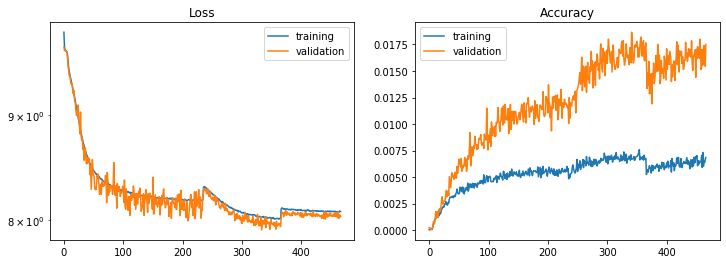

In [3]:
# Plot the training and validation losses.
tloss = np.loadtxt("train.txt")
vloss = np.loadtxt("val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [9]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
softmax = nn.Softmax(dim=1)
model.eval()

Created dataset for events from 0 to 100000


basicCNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=64, out_features=15876, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
)

In [10]:
SHIFTED_ERR_RANGE_MIN = tr.PIXEL_ERR_RANGE_MIN - dset.add_shift*tr.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = tr.PIXEL_ERR_RANGE_MAX + dset.add_shift*tr.PIXEL_SIZE
ERR_PIXEL_SIZE = tr.PIXEL_SIZE*(2*dset.add_shift+1)/tr.ERR_SIZE

def mult_gaussFun_Fit(x_y,*m):
    (x,y) = x_y
    A,x0,y0,varx,vary,C = m
    #print("x0 is {}".format(x0))
    X,Y = np.meshgrid(x,y)
    Z = A*np.exp(-0.5*((X-x0)**2/(varx)+(Y-y0)**2/(vary))) + C
    return Z.ravel()

# Compute sigma_x and sigma_y of the given probability distribution
def compute_sigmas(prob_dist):
    
    sum_tot = 0
    sum_x, sum_xsq = 0, 0
    sum_y, sum_ysq = 0, 0
    vmax = np.max(prob_dist)
    for i in range(prob_dist.size):
        
        xi = int(i % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
        yi = int(i / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
        
        vi = prob_dist[np.unravel_index(i,prob_dist.shape)]
        
        # Use a threshold of some fraction of vmax.
        if(vi > vmax / 10):
            sum_x   += xi*vi
            sum_xsq += xi**2*vi
            sum_y   += yi*vi
            sum_ysq += yi**2*vi
            sum_tot += vi
    
    # Compute mean and sigma.
    mean_x = sum_x/sum_tot
    mean_y = sum_y/sum_tot
    sigma_x = (sum_xsq/sum_tot - mean_x**2)**0.5
    sigma_y = (sum_ysq/sum_tot - mean_y**2)**0.5
    
    return sigma_x, sigma_y

def fit_sigmas(prob_dist,x,y,x0,y0,sigma_x0,sigma_y0):
    """
    Fit a 2D gaussian for sigma_x and sigma_y.
    
    prob_dist: the probability distribution
    x: a 1D list of the x-coordinates on the 2D grid (in mm)
    y: a 1D list of the y-coordinates on the 2D grid (in mm)
    x0: the initial guess for the x-value of the mean
    y0: the initial guess for the y-value of the mean
    sigma_x0: the initial guess for the sigma in the x-direction
    sigma_y0: the initial guess for the sigma in the y-direction
    """
    initial_guess = [np.max(prob_dist), x0, y0, sigma_x0**2, sigma_y0**2, np.max(prob_dist)/10.]
    bounds = ([0,x0-10*ERR_PIXEL_SIZE,y0-10*ERR_PIXEL_SIZE,0,0,0],[2*np.max(prob_dist),x0+10*ERR_PIXEL_SIZE,y0+10*ERR_PIXEL_SIZE,0.05,0.05,np.max(prob_dist)])
    
    try:
        popt, pcov = curve_fit(mult_gaussFun_Fit, (x, y), prob_dist.ravel(), p0=initial_guess, bounds=bounds)
    except (RuntimeError):
        print("Error in fit; using initial guess")
        return initial_guess,None
    
    return popt, pcov

In [11]:
evts = np.arange(80000,80100)

# Get the x and y coordinates of the 2D error prediction grid, in mm.
x_errgrid = np.arange(0,tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2

l_evt_arr = []
l_evt, l_xtrue, l_ytrue, l_xpred, l_ypred, l_sigma_x_NN, l_sigma_y_NN = [], [], [], [], [], [], []

l_n_above_threshold, l_sum_above_threshold, l_max_dist_above_threshold = [], [], []
l_xmax, l_ymax = [], []
l_m1_x_above_threshold, l_m1_y_above_threshold, l_m2_x_above_threshold, l_m2_y_above_threshold = [], [], [], []
l_xc_3x3, l_yc_3x3, l_xc_3x3_above_threshold, l_yc_3x3_above_threshold = [], [], [], []
l_xc_5x5, l_yc_5x5, l_xc_5x5_above_threshold, l_yc_5x5_above_threshold = [], [], [], []
for evt in evts:
    
    evt_item = dset[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()
    output_score = model(data)
    
    # Compute the predicted pixel and (x,y) values.
    prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([tr.ERR_SIZE,tr.ERR_SIZE])
    ipred = np.argmax(prob)
    xpred = int(ipred % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
    ypred = int(ipred / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
    #print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    # Compute the sigmas of the distribution.
    sigma_x0_NN, sigma_y0_NN = compute_sigmas(prob)
    popt, pcov = fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0_NN,sigma_y0_NN)
    xpred = popt[1]
    ypred = popt[2]
    sigma_x_NN = popt[3]**0.5
    sigma_y_NN = popt[4]**0.5
    
    [n_above_threshold, sum_above_threshold, max_dist_above_threshold, 
        xmax, ymax,
        m1x_above_threshold, m1y_above_threshold, m2x_above_threshold, m2y_above_threshold, 
        xc_3x3, yc_3x3, xc_3x3_above_threshold, yc_3x3_above_threshold,
        xc_5x5, yc_5x5, xc_5x5_above_threshold, yc_5x5_above_threshold] = compute_key_quantities(evt_arr,tr.PIXEL_SIZE)
    
    # Fill the lists.
    l_evt.append(evt)
    l_xtrue.append(evt_lbl[0])
    l_ytrue.append(evt_lbl[1])
    l_xpred.append(xpred)
    l_ypred.append(ypred)
    l_sigma_x_NN.append(sigma_x_NN)
    l_sigma_y_NN.append(sigma_y_NN)
    
    l_evt_arr.append(evt_arr)
    
    l_n_above_threshold.append(n_above_threshold)
    l_sum_above_threshold.append(sum_above_threshold)
    l_max_dist_above_threshold.append(max_dist_above_threshold)
    l_xmax.append(xmax)
    l_ymax.append(ymax)
    l_m1_x_above_threshold.append(m1x_above_threshold)
    l_m1_y_above_threshold.append(m1y_above_threshold)
    l_m2_x_above_threshold.append(m2x_above_threshold)
    l_m2_y_above_threshold.append(m2y_above_threshold)
    l_xc_3x3.append(xc_3x3)
    l_yc_3x3.append(yc_3x3)
    l_xc_3x3_above_threshold.append(xc_3x3_above_threshold)
    l_yc_3x3_above_threshold.append(yc_3x3_above_threshold)
    l_xc_5x5.append(xc_5x5)
    l_yc_5x5.append(yc_5x5)
    l_xc_5x5_above_threshold.append(xc_5x5_above_threshold)
    l_yc_5x5_above_threshold.append(yc_5x5_above_threshold)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
        print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))

# Create the dataframe.
evt_dict = {'event': l_evt, 'x_true': l_xtrue, 'y_true': l_ytrue, 'x_pred': l_xpred, 'y_pred': l_ypred, 
            'sigma_x_NN': l_sigma_x_NN, 'sigma_y_NN': l_sigma_y_NN,
            'n_above_threshold': l_n_above_threshold, 
            'sum_above_threshold': l_sum_above_threshold, 
            'max_dist_above_threshold': l_max_dist_above_threshold,
            'xmax_pixel': l_xmax,
            'ymax_pixel': l_ymax,
            'm1_x_above_threshold': l_m1_x_above_threshold, 
            'm1_y_above_threshold': l_m1_y_above_threshold,
            'm2_x_above_threshold': l_m2_x_above_threshold,
            'm2_y_above_threshold': l_m2_y_above_threshold,
            'xc_3x3': l_xc_3x3,
            'yc_3x3': l_yc_3x3,
            'xc_3x3_above_threshold': l_xc_3x3_above_threshold,
            'yc_3x3_above_threshold': l_yc_3x3_above_threshold,
            'xc_5x5': l_xc_5x5,
            'yc_5x5': l_yc_5x5,
            'xc_5x5_above_threshold': l_xc_5x5_above_threshold,
            'yc_5x5_above_threshold': l_yc_5x5_above_threshold}
df = pd.DataFrame.from_dict(evt_dict)

# Create derived quantities.
df["sigma_r_NN"] = (df.sigma_x_NN**2 + df.sigma_y_NN**2)**0.5
df["error_x_NN"] = df.x_pred - df.x_true
df["error_y_NN"] = df.y_pred - df.y_true
df["error_r_NN"] = (df.error_x_NN**2 + df.error_y_NN**2)**0.5
df["sigma_x_above_threshold"] = df.m2_x_above_threshold - df.m1_x_above_threshold**2
df["sigma_y_above_threshold"] = df.m2_y_above_threshold - df.m1_y_above_threshold**2
df["sigma_max_above_threshold"] = df[["sigma_x_above_threshold", "sigma_y_above_threshold"]].max(axis=1)
df["sigma_min_above_threshold"] = df[["sigma_x_above_threshold", "sigma_y_above_threshold"]].min(axis=1)
df["error_x_maxpt"] = df.xmax_pixel - df.x_true
df["error_y_maxpt"] = df.ymax_pixel - df.y_true
df["error_r_maxpt"] = (df.error_x_maxpt**2 + df.error_y_maxpt**2)**0.5
df["error_x_th"] = df.m1_x_above_threshold - df.x_true
df["error_y_th"] = df.m1_y_above_threshold - df.y_true
df["error_r_th"] = (df.error_x_th**2 + df.error_y_th**2)**0.5
df["error_x_3x3"] = df.xc_3x3 - df.x_true
df["error_y_3x3"] = df.yc_3x3 - df.y_true
df["error_r_3x3"] = (df.error_x_3x3**2 + df.error_y_3x3**2)**0.5
df["error_x_3x3_th"] = df.xc_3x3_above_threshold - df.x_true
df["error_y_3x3_th"] = df.yc_3x3_above_threshold - df.y_true
df["error_r_3x3_th"] = (df.error_x_3x3_th**2 + df.error_y_3x3_th**2)**0.5
df["error_x_5x5"] = df.xc_5x5 - df.x_true
df["error_y_5x5"] = df.yc_5x5 - df.y_true
df["error_r_5x5"] = (df.error_x_5x5**2 + df.error_y_5x5**2)**0.5
df["error_x_5x5_th"] = df.xc_5x5_above_threshold - df.x_true
df["error_y_5x5_th"] = df.yc_5x5_above_threshold - df.y_true
df["error_r_5x5_th"] = (df.error_x_5x5_th**2 + df.error_y_5x5_th**2)**0.5

0% done
1% done
2% done
3% done
4% done
5% done
6% done
7% done
8% done
9% done
10% done
11% done
12% done
13% done
14% done
15% done
16% done
17% done
18% done
19% done
20% done
21% done
22% done
23% done
24% done
25% done
26% done
27% done
28% done
29% done
30% done
31% done
32% done
33% done
34% done
35% done
36% done
37% done
38% done
39% done
40% done
41% done
42% done
43% done
44% done
45% done
46% done
47% done
48% done
49% done
50% done
51% done
52% done
53% done
54% done
55% done
56% done
57% done
58% done
59% done
60% done
61% done
62% done
63% done
64% done
65% done
66% done
67% done
68% done
69% done
70% done
71% done
72% done
73% done
74% done
75% done
76% done
77% done
78% done
79% done
80% done
81% done
82% done
83% done
84% done
85% done
86% done
87% done
88% done
89% done
90% done
91% done
92% done
93% done
94% done
95% done
96% done
97% done
98% done
99% done


In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

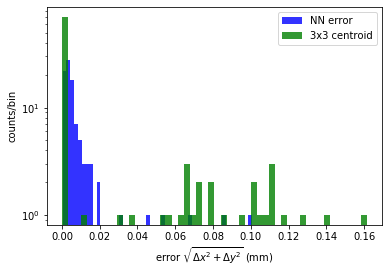

In [12]:
err_cut = 0.5
sigma_cut = 0.1
plt.hist(df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN,alpha=0.8,bins=50,color='blue',label='NN error')
plt.hist(df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3,alpha=0.8,bins=50,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
plt.yscale('log')
plt.legend()

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.01
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net

In [13]:
dset = tr.EMDataset("EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=10)
softmax = nn.Softmax(dim=1)
model.eval()

Created dataset for events from 0 to 100000


basicCNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=64, out_features=15876, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
)

Computed index: 10742 for max added shift: 10
Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:
A = 0.0001479951752463489
(x0, y0) = (-0.027174348571199075,0.013049341408148589)
(sigma_x, sigma_y) = (0.01411611885419817,0.005032849336356888)
C = 5.721160456295586e-05


Text(0.5, 1.0, '2D Gaussian fit')

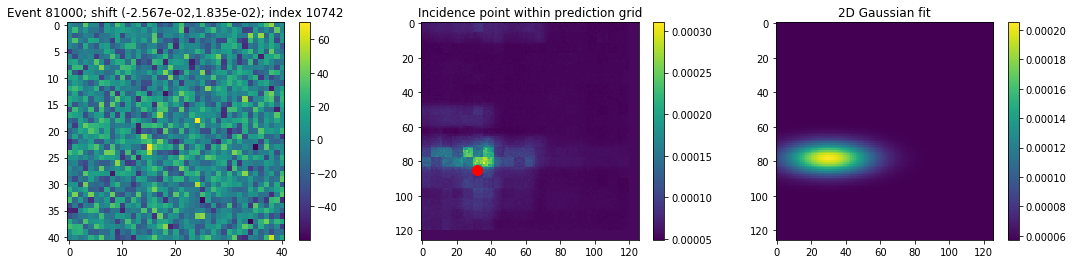

In [15]:
evt_plt = 81000
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = tr.PIXEL_ERR_RANGE_MIN - dset.add_shift*tr.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = tr.PIXEL_ERR_RANGE_MAX + dset.add_shift*tr.PIXEL_SIZE

xbin = int(tr.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,tr.ERR_SIZE-1)

ybin = int(tr.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,tr.ERR_SIZE-1)

print("Computed index:",(ybin*tr.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([tr.ERR_SIZE,tr.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / tr.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = compute_sigmas(prob)
popt, pcov = fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0)
fit_data = mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([tr.ERR_SIZE,tr.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")
